# Libraries

In [1]:
import os
import sys

import numpy as np
import pandas as pd

from tqdm import tqdm

import torch
import random

import matplotlib.pyplot as plt

# get the current script's directory
current_directory = os.path.dirname(os.path.abspath(__file__)) if "__file__" in locals() else os.getcwd()
# get the parent directory
parent_directory = os.path.dirname(current_directory)
# add the parent directory to the sys.path
sys.path.append(parent_directory)

from optimization import functions
from optimization.updater import Updater

from utils import constants, common
from utils.config import Config
from utils.dataset_loader import PolicyDatasetLoader

from models.policy_model import RobotPolicy
from models.reward_model import RewardFunction

from environment.environment import RobotEnvironment
from environment.buffer import ReplayBuffer

# Constants

In [2]:
D_demo, D_samp = torch.tensor([]), torch.tensor([])
mean_loss_reward, mean_loss_policy = [], []

EPISODES_TO_PLAY = 3 # 3
REWARD_FUNCTION_UPDATE = 1
POLICY_FUNCTION_UPDATE = 2
DEMO_BATCH = 128 # 16
NUM_EPOCHS = 1000

In [3]:
pd.set_option("display.max_columns", None)

current_path = os.getcwd()
parent_path = os.path.dirname(current_path)
grand_parent_path = os.path.dirname(parent_path)

results_path = os.path.join(grand_parent_path, "results")

In [4]:
configs = Config()
# call the parameters method to set the parameters
configs.parameters()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Training Device: ", device)
configs.device = device

configs = functions.setup_config(device=device)

# random.seed(configs.seed)
# np.random.seed(configs.seed)
# torch.manual_seed(configs.seed)

Current Time:  Feb_19_2024-15_49_58
Training Device:  cpu
Current Time:  Feb_19_2024-15_49_58


In [5]:
policy_saving_path, reward_saving_path = functions.create_directories(configs=configs,
                                                                      results_path=results_path,
                                                                      saving_policy=True,
                                                                      saving_reward=True)

json_paths_train, results_path = functions.get_directories(parent_directory=parent_directory,
                                                           data_folder_name=constants.DEMO_COLLECTION_DATE) # DEMO_COLLECTION_DATE, TEST_COLLECTION_DATE

In [6]:
training_data = PolicyDatasetLoader(demo_data_json_paths=json_paths_train)

train_loader = torch.utils.data.DataLoader(training_data,
                                           batch_size=configs.batch_size_policy,
                                           shuffle=configs.data_shuffle,
                                           num_workers=configs.num_workers)

trajectory_indices = functions.find_indices_of_trajectory_changes(dataset=training_data)

policy_network = RobotPolicy(state_size=configs.state_size,
                             hidden_size=configs.hidden_size,
                             out_size=configs.action_size,
                             log_std_min=configs.policy_log_std_min,
                             log_std_max=configs.policy_log_std_max,
                             device=configs.device)
reward_network = RewardFunction(state_size=configs.state_size,
                                hidden_size=configs.hidden_size,
                                out_size=configs.reward_size,
                                device=configs.device)

updater_obj = Updater(configs=configs,
                      policy_network=policy_network,
                      reward_network=reward_network)
reward_optimizer = updater_obj.initialize_optimizers()

env = RobotEnvironment()
env.set_reward_network(reward_network)
env.is_reward_inference = False

capacity = 10000
replay_buffer = ReplayBuffer(capacity=capacity)


================== Policy Dataset Loader ==================

Number of Trajectories:  43
Each Trajectory Length:  20
Full Demo Dataset Size:  879


# Functions

In [7]:
def calculate_discounted_return(rewards, gamma=0.99):
    # rewards: PyTorch tensor of shape [trajectory_length, 1]
    # gamma: Discount factor
    
    T = rewards.size(0)
    discounted_returns = torch.zeros(T, 1)
    
    for t in range(T):
        discounted_sum = 0
        for t_prime in range(t, T):
            discounted_sum += (gamma ** (t_prime - t)) * rewards[t_prime]
        discounted_returns[t] = discounted_sum
    
    return discounted_returns

In [8]:
def get_cumulative_rewards(rewards, gamma=0.99):
    G = torch.zeros_like(rewards, dtype=torch.float64)

    G[-1] = rewards[-1].clone()

    for idx in range(len(rewards) - 2, -1, -1):
        G[idx] = rewards[idx] + gamma * G[idx + 1]

    return G

In [9]:
def generate_session(t_max,
                     updater_obj,
                     replay_buffer,
                     is_policy_inference,
                     is_policy_update,
                     is_deterministic):
    pol_loss = None
    
    states, traj_log_probs, actions, rewards, entropy_values = [], [], [], [], []
    
    state = env.reset()
    
    for t in range(t_max):
        action, action_std, action_log_prob, entropy_value = policy_network.estimate_action(state=state,
                                                                                            is_policy_inference=is_policy_inference,
                                                                                            is_deterministic=is_deterministic)
        
        next_state, reward, done = env.step(state=state,
                                            action=action)
        
        states.append(state.clone())
        actions.append(action.clone())
        traj_log_probs.append(action_log_prob.clone())
        rewards.append(reward.clone())
        entropy_values.append(entropy_value.clone())
        
        replay_buffer.push(state,
                           action,
                           reward,
                           next_state,
                           done,
                           action_log_prob)
        
        state = next_state.detach()
        
        if done:
            
            if is_policy_update:
                
                entropy = torch.stack(entropy_values, dim=0).float().clone()
                cumulative_log_probs = torch.cumsum(torch.stack(traj_log_probs, dim=0).float().clone(), dim=0)
                
                # print("torch.stack(rewards, dim=0).float().clone() : ", torch.stack(rewards, dim=0).float().clone(), torch.stack(rewards, dim=0).float().clone().shape)
                
#                 cumulative_returns = get_cumulative_rewards(torch.stack(rewards, dim=0).float().clone(), 0.99)
                cumulative_returns = calculate_discounted_return(torch.stack(rewards, dim=0).float().clone(), 0.5)
                
#                 loss_policy = updater_obj.calculate_policy_gradient_loss(cumulative_log_probs=torch.stack(traj_log_probs, dim=0).float().clone().unsqueeze(1),
#                                                                          advantages=torch.stack(rewards, dim=0).float().clone(),
#                                                                          entropy=entropy)
                loss_policy = updater_obj.calculate_policy_gradient_loss(cumulative_log_probs=cumulative_log_probs.unsqueeze(1),
                                                                         advantages=cumulative_returns,
                                                                         entropy=entropy)
                updater_obj.run_policy_optimizer(policy_loss=loss_policy)
                pol_loss = loss_policy.detach().item()
                
                weighted_log_probs = cumulative_log_probs.unsqueeze(1) * cumulative_returns
                pl = - torch.mean(weighted_log_probs, dim=0)
                
#                 entr = torch.mean(torch.exp(cumulative_log_probs.unsqueeze(1)) * cumulative_log_probs.unsqueeze(1), dim=0)
                
                # TODO: kl divergence loss addition between human demonstration gaussian actions and predicted action distribution
                
#                 print("cumulative_log_probs : ", cumulative_log_probs)
#                 print("cumulative_log_probs.unsqueeze(1) : ", cumulative_log_probs.unsqueeze(1))
#                 print("cumulative_returns : ", cumulative_returns)
#                 print("weighted_log_probs : ", weighted_log_probs)
# #                 print("entr : ", entr)
#                 print("entropy : ", entropy)
#                 print("pl : ", pl)
#                 print("pol_loss : ", pol_loss)
                
            break
    
    return states, actions, traj_log_probs, rewards, pol_loss

In [10]:
def preprocess_traj(traj_list_,
                    step_tensor,
                    is_Demo=False):
    
    for traj_df in traj_list_:
        
        if is_Demo:
            states = torch.tensor(traj_df[["state_label_norm_1", "state_label_norm_2", "state_label_norm_3"]].values)
            actions = torch.tensor(traj_df[["action_label_norm_1", "action_label_norm_2", "action_label_norm_3"]].values)
            log_probs = torch.tensor(np.zeros((actions.shape[0], 1)))
        
        else:
            states = torch.stack(traj_df[0])
            actions = torch.stack(traj_df[1])
            log_probs = torch.stack(traj_df[3])
        
        mdp = torch.cat((states, log_probs, actions), dim=1)
        step_tensor = torch.cat((step_tensor.clone(), mdp.clone()), dim=0)
    
    return step_tensor

In [11]:
# def compute_annealing_factor(epoch):
    
#     initial_std_weight = 1.0
#     final_std_weight = 0.1
#     max_epoch = 300.0
    
#     fraction = min(1.0, epoch / max_epoch)
    
#     annealing_factor = initial_std_weight + fraction * (final_std_weight - initial_std_weight)
    
#     print("fraction : ", fraction)
#     print("annealing_factor : ", annealing_factor)
    
#     return annealing_factor

In [12]:
# Early Exploration: In the early stages of training, when the agent's knowledge is limited,
#     you want to encourage more exploration. By assigning a lower weight to the standard deviation term,
#     you are placing less emphasis on minimizing the standard deviation,
#     allowing the agent to explore the state space more thoroughly.

# Gradual Exploitation: As the agent gains more experience and learns a better policy,
#     you gradually increase the weight on the standard deviation term.
#     This encourages the agent to reduce its exploration and focus more on exploiting the learned policy.
#     Increasing the weight on the standard deviation term can help stabilize the policy as
#     the agent converges towards a more deterministic behavior.

def compute_annealing_factor(epoch):
    
    max_epochs = NUM_EPOCHS
    initial_std_weight = 0.05
    final_std_weight = 1.0
    
    fraction = min(1.0, epoch / max_epochs)
    
    annealing_factor = initial_std_weight + fraction * (final_std_weight - initial_std_weight)
    
#     print("fraction : ", fraction)
#     print("annealing_factor : ", annealing_factor)
    
    return annealing_factor

# Tests

In [13]:
demo_traj_list = []

for traj_start_index in range(len(trajectory_indices)):
    
    traj_df, reward_values_demo_data, reward_values_estim_data, logprob_action_estim_avg = \
        functions.get_estimated_rewards(configs=configs,
                                        updater_obj=updater_obj,
                                        data_loader=training_data,
                                        policy_network=updater_obj.policy_network,
                                        reward_network=updater_obj.reward_network,
                                        trajectory_indices=trajectory_indices,
                                        traj_start_index=traj_start_index,
                                        is_inference_reward=True,
                                        is_inference_policy=True,
                                        is_deterministic=True)
    demo_traj_list.append(traj_df)
    del traj_df

In [14]:
D_demo = preprocess_traj(traj_list_=demo_traj_list,
                         step_tensor=D_demo,
                         is_Demo=True)

# Test BC

In [15]:
# bc_training_epochs = 50

# for epoch in range(bc_training_epochs):
    
#     # loop through each batch inside the dataset
#     for batch_train_data in tqdm(train_loader):
        
#         # get batch of data
#         input_state, output_action, _, _ = functions.read_each_loader(configs=configs,
#                                                                       sample_data=tuple(batch_train_data))
        
#         # forward pass to get mean of Gaussian distribution
#         action, action_std, action_log_prob, action_entropy = policy_network.estimate_action(state=input_state,
#                                                                                              is_policy_inference=False)
        
#         # compute negative log-likelihood loss value for maximum likelihood estimation
#         loss_bc_traj = updater_obj.multivariate_gaussian_nll_loss(y_true=output_action,
#                                                                   mu=action,
#                                                                   log_sigma=action_std)
# #         print("output_action : ", output_action)
# #         print("action : ", action)
#         print("loss_bc_traj : ", loss_bc_traj)
#         batch_loss = loss_bc_traj.mean()
        
#         updater_obj.run_policy_optimizer(policy_loss=loss_bc_traj)
        
#         loss_value = round(batch_loss.item(), 5)
#         loss_value_str = str(loss_value).replace(".", "_")
        
#     print(f"Epoch {epoch + 1}/{bc_training_epochs}, Batch Loss: {loss_value}")

# Test PG

In [16]:
# for i in range(500):
#     print("Epoch : ", i)
#     for _ in range(EPISODES_TO_PLAY):
#         samp_trajs = generate_session(t_max=constants.TRAJECTORY_SIZE,
#                                       updater_obj=updater_obj,
#                                       replay_buffer=replay_buffer,
#                                       is_policy_inference=False,
#                                       is_policy_update=True)

In [17]:
# samp_trajs

# Reward Optimization

In [18]:
all_policy_loss = []
mean_reward_value = []

for i in range(NUM_EPOCHS):
    
    samp_trajs = [generate_session(t_max=constants.TRAJECTORY_SIZE,
                                   updater_obj=updater_obj,
                                   replay_buffer=replay_buffer,
                                   is_policy_inference=True,
                                   is_policy_update=False,
                                   is_deterministic=False) for _ in range(EPISODES_TO_PLAY)]
    
    samp_reward_values = []
    for traji in samp_trajs:
        rewardii = traji[3]
        for rewardi in rewardii:
            samp_reward_values.append(rewardi.item())
    
    D_samp = preprocess_traj(traj_list_=samp_trajs,
                             step_tensor=D_samp,
                             is_Demo=False)
    
    loss_reward, loss_policy = [], []
#     samp_reward_values = []
    is_early_stop = False
    
    for _ in range(REWARD_FUNCTION_UPDATE):
        
        selected_samp = np.random.choice(len(D_samp), int(DEMO_BATCH/2), replace=True)
        selected_demo = np.random.choice(len(D_demo), int(DEMO_BATCH), replace=False)
        
        D_s_samp = D_samp[selected_samp].clone().detach()
        D_s_demo = D_demo[selected_demo].clone().detach()
        
        D_s_samp = torch.cat((D_s_demo, D_s_samp), dim=0)
        D_sr_samp = D_s_samp[torch.randperm(int(D_s_samp.size(0)))]
        
        states_robot, log_probs_robot, actions_robot = D_sr_samp[:, :3], D_sr_samp[:, 3:4], D_sr_samp[:, 4:]
        states_expert, actions_expert = D_s_demo[:, :3], D_s_demo[:, 4:]
        
        samp_rewards = updater_obj.reward_network.estimate_reward(state=states_robot.float(), is_reward_inference=False)
        demo_rewards = updater_obj.reward_network.estimate_reward(state=states_expert.float(), is_reward_inference=False)
        
        loss_IOC = - torch.mean(demo_rewards) + torch.log(torch.mean(torch.exp(samp_rewards) / (torch.exp(log_probs_robot) + 1e-7)))
#         loss_IOC = - torch.mean(demo_rewards) #+ torch.log(torch.mean(torch.exp(samp_rewards) / (torch.exp(log_probs_robot) + 1e-7)))
        
        # print("loss_IOC : ", loss_IOC.detach().numpy())
        # print("torch.mean(demo_rewards) : ", torch.mean(demo_rewards))
        
        updater_obj.run_reward_optimizer(reward_loss=loss_IOC)
        
        loss_reward.append(loss_IOC.detach().item())
        
        if torch.mean(demo_rewards) >= 0.99:
            is_early_stop = True
    
    # compute standar deviation minimization weight based on the annealing strategy
    std_weight = compute_annealing_factor(epoch=i)
    
    bc_training_epochs = 1
    for epoch in range(bc_training_epochs):

        # loop through each batch inside the dataset
        for batch_train_data in tqdm(train_loader):

            # get batch of data
            input_state, output_action, _, _ = functions.read_each_loader(configs=configs,
                                                                          sample_data=tuple(batch_train_data))

            # forward pass to get mean of Gaussian distribution
            action, action_std, action_log_prob, action_entropy = policy_network.estimate_action(state=input_state,
                                                                                                 is_policy_inference=False,
                                                                                                 is_deterministic=True)

            # compute negative log-likelihood loss value for maximum likelihood estimation
            loss_bc_traj = updater_obj.multivariate_gaussian_nll_loss(action_true=output_action,
                                                                      action_pred_mu=action,
                                                                      action_log_std=torch.log(action_std),
                                                                      std_weight=std_weight)
    #         print("output_action : ", output_action)
    #         print("action : ", action)
            # print("loss_bc_traj : ", loss_bc_traj)
            batch_loss = loss_bc_traj.mean()

            updater_obj.run_policy_optimizer(policy_loss=loss_bc_traj)

            loss_value = round(batch_loss.item(), 5)
            loss_value_str = str(loss_value).replace(".", "_")
            
        loss_policy.append(loss_value)

        print("Epoch : ", i, f"Epoch {epoch + 1}/{bc_training_epochs}, Batch Loss: {loss_value}")
    
#     for _ in range(POLICY_FUNCTION_UPDATE):
#         samp_trajs = generate_session(t_max=constants.TRAJECTORY_SIZE,
#                                       updater_obj=updater_obj,
#                                       replay_buffer=replay_buffer,
#                                       is_policy_inference=False,
#                                       is_policy_update=True)
        
#         loss_policy.append(samp_trajs[4])
#         all_policy_loss.append(samp_trajs[4])
#         samp_reward_values.append(torch.mean(torch.stack(samp_trajs[3])).item())
    
    mean_loss_reward.append(np.mean(loss_reward))
    mean_loss_policy.append(np.mean(loss_policy))
    mean_reward_value.append(np.mean(samp_reward_values))
    
#     if i % 10 == 0:
#         print("Avg. Reward : ", torch.mean(rewards_tensor).item())
#         functions.save_reward(epoch=i,
#                               reward_network=updater_obj.reward_network,
#                               saving_path=reward_saving_path,
#                               loss_value_str=str(abs(np.mean(loss_reward))).replace(".", "_"))
#         functions.save_policy(epoch=i,
#                               policy_network=updater_obj.policy_network,
#                               saving_path=policy_saving_path,
#                               loss_value_str=str(abs(np.mean(loss_policy))).replace(".", "_"))
    
#     if is_early_stop:
#         break

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.43it/s]


Epoch :  0 Epoch 1/1, Batch Loss: 48.08291


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.99it/s]


Epoch :  1 Epoch 1/1, Batch Loss: 46.3733


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.74it/s]


Epoch :  2 Epoch 1/1, Batch Loss: 46.83238


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.41it/s]


Epoch :  3 Epoch 1/1, Batch Loss: 45.19479


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.77it/s]


Epoch :  4 Epoch 1/1, Batch Loss: 45.25866


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.20it/s]


Epoch :  5 Epoch 1/1, Batch Loss: 45.39006


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.64it/s]


Epoch :  6 Epoch 1/1, Batch Loss: 46.81293


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.71it/s]


Epoch :  7 Epoch 1/1, Batch Loss: 46.30909


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.95it/s]


Epoch :  8 Epoch 1/1, Batch Loss: 44.22013


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.87it/s]


Epoch :  9 Epoch 1/1, Batch Loss: 44.892


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.76it/s]


Epoch :  10 Epoch 1/1, Batch Loss: 44.21898


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.27it/s]


Epoch :  11 Epoch 1/1, Batch Loss: 45.0025


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.00it/s]


Epoch :  12 Epoch 1/1, Batch Loss: 44.87811


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.07it/s]


Epoch :  13 Epoch 1/1, Batch Loss: 45.11611


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.22it/s]


Epoch :  14 Epoch 1/1, Batch Loss: 44.22158


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.48it/s]


Epoch :  15 Epoch 1/1, Batch Loss: 44.3756


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.29it/s]


Epoch :  16 Epoch 1/1, Batch Loss: 44.9837


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.13it/s]


Epoch :  17 Epoch 1/1, Batch Loss: 43.84815


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.05it/s]


Epoch :  18 Epoch 1/1, Batch Loss: 44.08788


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.34it/s]


Epoch :  19 Epoch 1/1, Batch Loss: 43.87646


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.82it/s]


Epoch :  20 Epoch 1/1, Batch Loss: 43.69992


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.34it/s]


Epoch :  21 Epoch 1/1, Batch Loss: 44.2957


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.11it/s]


Epoch :  22 Epoch 1/1, Batch Loss: 43.11884


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.37it/s]


Epoch :  23 Epoch 1/1, Batch Loss: 43.16209


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.16it/s]


Epoch :  24 Epoch 1/1, Batch Loss: 43.01251


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.97it/s]


Epoch :  25 Epoch 1/1, Batch Loss: 43.08968


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.94it/s]


Epoch :  26 Epoch 1/1, Batch Loss: 42.82737


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.57it/s]


Epoch :  27 Epoch 1/1, Batch Loss: 42.71767


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 24.72it/s]


Epoch :  28 Epoch 1/1, Batch Loss: 42.3977


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 24.95it/s]


Epoch :  29 Epoch 1/1, Batch Loss: 42.53957


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.27it/s]


Epoch :  30 Epoch 1/1, Batch Loss: 42.56909


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 24.98it/s]


Epoch :  31 Epoch 1/1, Batch Loss: 42.48135


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.40it/s]


Epoch :  32 Epoch 1/1, Batch Loss: 42.58911


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.90it/s]


Epoch :  33 Epoch 1/1, Batch Loss: 42.15566


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.10it/s]


Epoch :  34 Epoch 1/1, Batch Loss: 42.05924


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.28it/s]


Epoch :  35 Epoch 1/1, Batch Loss: 41.87186


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.45it/s]


Epoch :  36 Epoch 1/1, Batch Loss: 42.16445


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.79it/s]


Epoch :  37 Epoch 1/1, Batch Loss: 42.06969


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.58it/s]


Epoch :  38 Epoch 1/1, Batch Loss: 41.75141


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.07it/s]


Epoch :  39 Epoch 1/1, Batch Loss: 41.97271


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.46it/s]


Epoch :  40 Epoch 1/1, Batch Loss: 42.04464


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.36it/s]


Epoch :  41 Epoch 1/1, Batch Loss: 41.33535


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.04it/s]


Epoch :  42 Epoch 1/1, Batch Loss: 41.34301


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 24.61it/s]


Epoch :  43 Epoch 1/1, Batch Loss: 41.23755


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.58it/s]


Epoch :  44 Epoch 1/1, Batch Loss: 40.76391


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.74it/s]


Epoch :  45 Epoch 1/1, Batch Loss: 40.66361


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.56it/s]


Epoch :  46 Epoch 1/1, Batch Loss: 41.37086


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.44it/s]


Epoch :  47 Epoch 1/1, Batch Loss: 41.04041


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 28.36it/s]


Epoch :  48 Epoch 1/1, Batch Loss: 41.21066


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.46it/s]


Epoch :  49 Epoch 1/1, Batch Loss: 40.82462


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.94it/s]


Epoch :  50 Epoch 1/1, Batch Loss: 40.68869


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.58it/s]


Epoch :  51 Epoch 1/1, Batch Loss: 40.89435


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.25it/s]


Epoch :  52 Epoch 1/1, Batch Loss: 40.66879


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.32it/s]


Epoch :  53 Epoch 1/1, Batch Loss: 40.70782


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.76it/s]


Epoch :  54 Epoch 1/1, Batch Loss: 40.44146


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.26it/s]


Epoch :  55 Epoch 1/1, Batch Loss: 40.59768


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.23it/s]


Epoch :  56 Epoch 1/1, Batch Loss: 40.40893


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.37it/s]


Epoch :  57 Epoch 1/1, Batch Loss: 39.96319


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.47it/s]


Epoch :  58 Epoch 1/1, Batch Loss: 40.0841


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.30it/s]


Epoch :  59 Epoch 1/1, Batch Loss: 40.08892


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.19it/s]


Epoch :  60 Epoch 1/1, Batch Loss: 39.79337


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.15it/s]


Epoch :  61 Epoch 1/1, Batch Loss: 39.64808


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.73it/s]


Epoch :  62 Epoch 1/1, Batch Loss: 39.68806


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.84it/s]


Epoch :  63 Epoch 1/1, Batch Loss: 39.5474


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.26it/s]


Epoch :  64 Epoch 1/1, Batch Loss: 39.4545


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.54it/s]


Epoch :  65 Epoch 1/1, Batch Loss: 39.79933


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.44it/s]


Epoch :  66 Epoch 1/1, Batch Loss: 39.26075


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 24.91it/s]


Epoch :  67 Epoch 1/1, Batch Loss: 39.1656


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.67it/s]


Epoch :  68 Epoch 1/1, Batch Loss: 39.02744


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.54it/s]


Epoch :  69 Epoch 1/1, Batch Loss: 39.36553


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.55it/s]


Epoch :  70 Epoch 1/1, Batch Loss: 39.35214


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 24.45it/s]


Epoch :  71 Epoch 1/1, Batch Loss: 38.97056


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.16it/s]


Epoch :  72 Epoch 1/1, Batch Loss: 38.91234


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 24.98it/s]


Epoch :  73 Epoch 1/1, Batch Loss: 38.61662


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.00it/s]


Epoch :  74 Epoch 1/1, Batch Loss: 38.4298


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.11it/s]


Epoch :  75 Epoch 1/1, Batch Loss: 38.17392


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.37it/s]


Epoch :  76 Epoch 1/1, Batch Loss: 38.29803


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.90it/s]


Epoch :  77 Epoch 1/1, Batch Loss: 38.32306


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.26it/s]


Epoch :  78 Epoch 1/1, Batch Loss: 38.20655


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.38it/s]


Epoch :  79 Epoch 1/1, Batch Loss: 38.27683


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.18it/s]


Epoch :  80 Epoch 1/1, Batch Loss: 37.94631


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.55it/s]


Epoch :  81 Epoch 1/1, Batch Loss: 38.55366


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.01it/s]


Epoch :  82 Epoch 1/1, Batch Loss: 37.43486


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 23.12it/s]


Epoch :  83 Epoch 1/1, Batch Loss: 37.52824


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.14it/s]


Epoch :  84 Epoch 1/1, Batch Loss: 37.72707


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 24.24it/s]


Epoch :  85 Epoch 1/1, Batch Loss: 37.32412


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.18it/s]


Epoch :  86 Epoch 1/1, Batch Loss: 37.6384


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.69it/s]


Epoch :  87 Epoch 1/1, Batch Loss: 37.5285


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.15it/s]


Epoch :  88 Epoch 1/1, Batch Loss: 37.29932


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.61it/s]


Epoch :  89 Epoch 1/1, Batch Loss: 37.41545


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.91it/s]


Epoch :  90 Epoch 1/1, Batch Loss: 37.20068


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.61it/s]


Epoch :  91 Epoch 1/1, Batch Loss: 38.4847


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.53it/s]


Epoch :  92 Epoch 1/1, Batch Loss: 36.58203


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.18it/s]


Epoch :  93 Epoch 1/1, Batch Loss: 36.99256


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.67it/s]


Epoch :  94 Epoch 1/1, Batch Loss: 37.00913


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.51it/s]


Epoch :  95 Epoch 1/1, Batch Loss: 37.48178


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 23.75it/s]


Epoch :  96 Epoch 1/1, Batch Loss: 36.80753


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.58it/s]


Epoch :  97 Epoch 1/1, Batch Loss: 36.79055


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.45it/s]


Epoch :  98 Epoch 1/1, Batch Loss: 37.08273


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.70it/s]


Epoch :  99 Epoch 1/1, Batch Loss: 36.82782


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.50it/s]


Epoch :  100 Epoch 1/1, Batch Loss: 36.50444


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.85it/s]


Epoch :  101 Epoch 1/1, Batch Loss: 36.16339


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.94it/s]


Epoch :  102 Epoch 1/1, Batch Loss: 36.1891


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.53it/s]


Epoch :  103 Epoch 1/1, Batch Loss: 36.51635


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.42it/s]


Epoch :  104 Epoch 1/1, Batch Loss: 36.78359


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.57it/s]


Epoch :  105 Epoch 1/1, Batch Loss: 36.27477


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.59it/s]


Epoch :  106 Epoch 1/1, Batch Loss: 35.75313


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.09it/s]


Epoch :  107 Epoch 1/1, Batch Loss: 35.49689


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.64it/s]


Epoch :  108 Epoch 1/1, Batch Loss: 35.71183


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.17it/s]


Epoch :  109 Epoch 1/1, Batch Loss: 36.27696


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.06it/s]


Epoch :  110 Epoch 1/1, Batch Loss: 36.3317


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.42it/s]


Epoch :  111 Epoch 1/1, Batch Loss: 34.98368


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 24.85it/s]


Epoch :  112 Epoch 1/1, Batch Loss: 35.90978


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 24.46it/s]


Epoch :  113 Epoch 1/1, Batch Loss: 36.35017


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.17it/s]


Epoch :  114 Epoch 1/1, Batch Loss: 34.51501


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.33it/s]


Epoch :  115 Epoch 1/1, Batch Loss: 36.34367


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.45it/s]


Epoch :  116 Epoch 1/1, Batch Loss: 34.98129


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.61it/s]


Epoch :  117 Epoch 1/1, Batch Loss: 35.2225


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.17it/s]


Epoch :  118 Epoch 1/1, Batch Loss: 35.0045


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.88it/s]


Epoch :  119 Epoch 1/1, Batch Loss: 34.86796


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.95it/s]


Epoch :  120 Epoch 1/1, Batch Loss: 35.25086


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.62it/s]


Epoch :  121 Epoch 1/1, Batch Loss: 35.11417


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.70it/s]


Epoch :  122 Epoch 1/1, Batch Loss: 35.12646


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.01it/s]


Epoch :  123 Epoch 1/1, Batch Loss: 35.73835


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.32it/s]


Epoch :  124 Epoch 1/1, Batch Loss: 34.52232


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.72it/s]


Epoch :  125 Epoch 1/1, Batch Loss: 35.63984


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.83it/s]


Epoch :  126 Epoch 1/1, Batch Loss: 35.32723


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.02it/s]


Epoch :  127 Epoch 1/1, Batch Loss: 34.28588


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 24.30it/s]


Epoch :  128 Epoch 1/1, Batch Loss: 33.87378


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.22it/s]


Epoch :  129 Epoch 1/1, Batch Loss: 34.3667


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 23.13it/s]


Epoch :  130 Epoch 1/1, Batch Loss: 33.26158


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 20.69it/s]


Epoch :  131 Epoch 1/1, Batch Loss: 34.48845


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.15it/s]


Epoch :  132 Epoch 1/1, Batch Loss: 35.2876


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 23.58it/s]


Epoch :  133 Epoch 1/1, Batch Loss: 33.25795


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 24.75it/s]


Epoch :  134 Epoch 1/1, Batch Loss: 32.71782


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 19.55it/s]


Epoch :  135 Epoch 1/1, Batch Loss: 32.56224


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 20.08it/s]


Epoch :  136 Epoch 1/1, Batch Loss: 33.0369


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 21.71it/s]


Epoch :  137 Epoch 1/1, Batch Loss: 32.79905


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 21.62it/s]


Epoch :  138 Epoch 1/1, Batch Loss: 32.30442


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 23.86it/s]


Epoch :  139 Epoch 1/1, Batch Loss: 32.93296


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 22.57it/s]


Epoch :  140 Epoch 1/1, Batch Loss: 33.17591


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 24.11it/s]


Epoch :  141 Epoch 1/1, Batch Loss: 32.94506


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 23.68it/s]


Epoch :  142 Epoch 1/1, Batch Loss: 33.05052


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 22.61it/s]


Epoch :  143 Epoch 1/1, Batch Loss: 33.11556


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 24.10it/s]


Epoch :  144 Epoch 1/1, Batch Loss: 32.23742


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 22.19it/s]


Epoch :  145 Epoch 1/1, Batch Loss: 32.80116


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 22.93it/s]


Epoch :  146 Epoch 1/1, Batch Loss: 31.64147


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.76it/s]


Epoch :  147 Epoch 1/1, Batch Loss: 34.33812


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.78it/s]


Epoch :  148 Epoch 1/1, Batch Loss: 33.72406


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 24.54it/s]


Epoch :  149 Epoch 1/1, Batch Loss: 32.97478


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 24.94it/s]


Epoch :  150 Epoch 1/1, Batch Loss: 31.80773


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.25it/s]


Epoch :  151 Epoch 1/1, Batch Loss: 32.23491


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.21it/s]


Epoch :  152 Epoch 1/1, Batch Loss: 31.63888


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.77it/s]


Epoch :  153 Epoch 1/1, Batch Loss: 31.27539


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 24.58it/s]


Epoch :  154 Epoch 1/1, Batch Loss: 32.37948


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 21.64it/s]


Epoch :  155 Epoch 1/1, Batch Loss: 31.26861


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 19.65it/s]


Epoch :  156 Epoch 1/1, Batch Loss: 30.78012


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 20.55it/s]


Epoch :  157 Epoch 1/1, Batch Loss: 31.83129


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 21.41it/s]


Epoch :  158 Epoch 1/1, Batch Loss: 31.10699


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 20.65it/s]


Epoch :  159 Epoch 1/1, Batch Loss: 30.80099


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 20.02it/s]


Epoch :  160 Epoch 1/1, Batch Loss: 31.64228


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 23.22it/s]


Epoch :  161 Epoch 1/1, Batch Loss: 30.90082


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 21.29it/s]


Epoch :  162 Epoch 1/1, Batch Loss: 30.3758


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 23.15it/s]


Epoch :  163 Epoch 1/1, Batch Loss: 30.84387


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 21.80it/s]


Epoch :  164 Epoch 1/1, Batch Loss: 29.27325


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 22.11it/s]


Epoch :  165 Epoch 1/1, Batch Loss: 29.77592


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 16.68it/s]


Epoch :  166 Epoch 1/1, Batch Loss: 29.97904


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.25it/s]


Epoch :  167 Epoch 1/1, Batch Loss: 31.18569


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.66it/s]


Epoch :  168 Epoch 1/1, Batch Loss: 31.45795


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 20.93it/s]


Epoch :  169 Epoch 1/1, Batch Loss: 30.03578


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 22.40it/s]


Epoch :  170 Epoch 1/1, Batch Loss: 28.88015


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 21.25it/s]


Epoch :  171 Epoch 1/1, Batch Loss: 29.04287


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 22.46it/s]


Epoch :  172 Epoch 1/1, Batch Loss: 28.87238


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 16.40it/s]


Epoch :  173 Epoch 1/1, Batch Loss: 29.04139


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 22.23it/s]


Epoch :  174 Epoch 1/1, Batch Loss: 28.82578


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 23.82it/s]


Epoch :  175 Epoch 1/1, Batch Loss: 29.15297


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 24.07it/s]


Epoch :  176 Epoch 1/1, Batch Loss: 29.90258


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.15it/s]


Epoch :  177 Epoch 1/1, Batch Loss: 27.76515


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.42it/s]


Epoch :  178 Epoch 1/1, Batch Loss: 29.49875


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.94it/s]


Epoch :  179 Epoch 1/1, Batch Loss: 28.61793


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.94it/s]


Epoch :  180 Epoch 1/1, Batch Loss: 28.51052


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.00it/s]


Epoch :  181 Epoch 1/1, Batch Loss: 28.09832


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.97it/s]


Epoch :  182 Epoch 1/1, Batch Loss: 28.55438


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.37it/s]


Epoch :  183 Epoch 1/1, Batch Loss: 27.59277


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.19it/s]


Epoch :  184 Epoch 1/1, Batch Loss: 27.2292


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.65it/s]


Epoch :  185 Epoch 1/1, Batch Loss: 28.44879


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.56it/s]


Epoch :  186 Epoch 1/1, Batch Loss: 30.31779


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.11it/s]


Epoch :  187 Epoch 1/1, Batch Loss: 27.66027


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.11it/s]


Epoch :  188 Epoch 1/1, Batch Loss: 26.86476


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.82it/s]


Epoch :  189 Epoch 1/1, Batch Loss: 27.45018


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.31it/s]


Epoch :  190 Epoch 1/1, Batch Loss: 28.35879


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.60it/s]


Epoch :  191 Epoch 1/1, Batch Loss: 28.38983


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.62it/s]


Epoch :  192 Epoch 1/1, Batch Loss: 26.7192


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.43it/s]


Epoch :  193 Epoch 1/1, Batch Loss: 29.23626


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.53it/s]


Epoch :  194 Epoch 1/1, Batch Loss: 27.39234


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.67it/s]


Epoch :  195 Epoch 1/1, Batch Loss: 27.65868


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.68it/s]


Epoch :  196 Epoch 1/1, Batch Loss: 26.89815


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.70it/s]


Epoch :  197 Epoch 1/1, Batch Loss: 29.9752


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.19it/s]


Epoch :  198 Epoch 1/1, Batch Loss: 27.59057


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.84it/s]


Epoch :  199 Epoch 1/1, Batch Loss: 27.00428


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.42it/s]


Epoch :  200 Epoch 1/1, Batch Loss: 26.35146


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.33it/s]


Epoch :  201 Epoch 1/1, Batch Loss: 26.82061


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.15it/s]


Epoch :  202 Epoch 1/1, Batch Loss: 26.26736


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.26it/s]


Epoch :  203 Epoch 1/1, Batch Loss: 29.34621


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.49it/s]


Epoch :  204 Epoch 1/1, Batch Loss: 26.97108


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.31it/s]


Epoch :  205 Epoch 1/1, Batch Loss: 24.85636


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.20it/s]


Epoch :  206 Epoch 1/1, Batch Loss: 26.9336


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 28.19it/s]


Epoch :  207 Epoch 1/1, Batch Loss: 27.99715


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.50it/s]


Epoch :  208 Epoch 1/1, Batch Loss: 28.05469


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.51it/s]


Epoch :  209 Epoch 1/1, Batch Loss: 24.65431


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.43it/s]


Epoch :  210 Epoch 1/1, Batch Loss: 26.84542


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.70it/s]


Epoch :  211 Epoch 1/1, Batch Loss: 27.17447


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.34it/s]


Epoch :  212 Epoch 1/1, Batch Loss: 24.25316


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.31it/s]


Epoch :  213 Epoch 1/1, Batch Loss: 25.8954


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.40it/s]


Epoch :  214 Epoch 1/1, Batch Loss: 24.40714


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.72it/s]


Epoch :  215 Epoch 1/1, Batch Loss: 24.4673


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.21it/s]


Epoch :  216 Epoch 1/1, Batch Loss: 26.54653


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 28.37it/s]


Epoch :  217 Epoch 1/1, Batch Loss: 24.66705


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.47it/s]


Epoch :  218 Epoch 1/1, Batch Loss: 23.96765


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.79it/s]


Epoch :  219 Epoch 1/1, Batch Loss: 25.45802


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.91it/s]


Epoch :  220 Epoch 1/1, Batch Loss: 23.72643


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 28.15it/s]


Epoch :  221 Epoch 1/1, Batch Loss: 24.69847


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.06it/s]


Epoch :  222 Epoch 1/1, Batch Loss: 24.61855


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.60it/s]


Epoch :  223 Epoch 1/1, Batch Loss: 24.47546


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.61it/s]


Epoch :  224 Epoch 1/1, Batch Loss: 23.88863


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.63it/s]


Epoch :  225 Epoch 1/1, Batch Loss: 26.00922


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.21it/s]


Epoch :  226 Epoch 1/1, Batch Loss: 24.5356


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.86it/s]


Epoch :  227 Epoch 1/1, Batch Loss: 24.55962


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.85it/s]


Epoch :  228 Epoch 1/1, Batch Loss: 22.73338


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 28.62it/s]


Epoch :  229 Epoch 1/1, Batch Loss: 23.2393


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 28.10it/s]


Epoch :  230 Epoch 1/1, Batch Loss: 23.00844


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.79it/s]


Epoch :  231 Epoch 1/1, Batch Loss: 24.62107


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.40it/s]


Epoch :  232 Epoch 1/1, Batch Loss: 24.01949


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.30it/s]


Epoch :  233 Epoch 1/1, Batch Loss: 25.41768


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.59it/s]


Epoch :  234 Epoch 1/1, Batch Loss: 23.33468


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.71it/s]


Epoch :  235 Epoch 1/1, Batch Loss: 22.27803


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.61it/s]


Epoch :  236 Epoch 1/1, Batch Loss: 20.79449


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.72it/s]


Epoch :  237 Epoch 1/1, Batch Loss: 22.59254


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 28.17it/s]


Epoch :  238 Epoch 1/1, Batch Loss: 22.38488


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.60it/s]


Epoch :  239 Epoch 1/1, Batch Loss: 22.39678


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.62it/s]


Epoch :  240 Epoch 1/1, Batch Loss: 21.10879


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 23.62it/s]


Epoch :  241 Epoch 1/1, Batch Loss: 25.39697


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 21.98it/s]


Epoch :  242 Epoch 1/1, Batch Loss: 20.69313


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 21.88it/s]


Epoch :  243 Epoch 1/1, Batch Loss: 24.67902


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 21.11it/s]


Epoch :  244 Epoch 1/1, Batch Loss: 21.34025


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 24.57it/s]


Epoch :  245 Epoch 1/1, Batch Loss: 21.94942


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 20.63it/s]


Epoch :  246 Epoch 1/1, Batch Loss: 21.32941


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 21.21it/s]


Epoch :  247 Epoch 1/1, Batch Loss: 21.61942


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 21.16it/s]


Epoch :  248 Epoch 1/1, Batch Loss: 23.1163


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 22.70it/s]


Epoch :  249 Epoch 1/1, Batch Loss: 22.25325


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 21.14it/s]


Epoch :  250 Epoch 1/1, Batch Loss: 22.23917


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 21.04it/s]


Epoch :  251 Epoch 1/1, Batch Loss: 21.63531


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 20.63it/s]


Epoch :  252 Epoch 1/1, Batch Loss: 21.13862


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 20.79it/s]


Epoch :  253 Epoch 1/1, Batch Loss: 21.29666


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 20.12it/s]


Epoch :  254 Epoch 1/1, Batch Loss: 20.7663


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 20.39it/s]


Epoch :  255 Epoch 1/1, Batch Loss: 19.22603


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 20.07it/s]


Epoch :  256 Epoch 1/1, Batch Loss: 18.24964


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 20.72it/s]


Epoch :  257 Epoch 1/1, Batch Loss: 20.29089


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 21.24it/s]


Epoch :  258 Epoch 1/1, Batch Loss: 20.64997


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 21.92it/s]


Epoch :  259 Epoch 1/1, Batch Loss: 21.34529


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 22.33it/s]


Epoch :  260 Epoch 1/1, Batch Loss: 20.35963


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 20.51it/s]


Epoch :  261 Epoch 1/1, Batch Loss: 21.0738


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 23.33it/s]


Epoch :  262 Epoch 1/1, Batch Loss: 19.86723


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 22.45it/s]


Epoch :  263 Epoch 1/1, Batch Loss: 18.62343


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 24.36it/s]


Epoch :  264 Epoch 1/1, Batch Loss: 19.54017


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 23.36it/s]


Epoch :  265 Epoch 1/1, Batch Loss: 19.75499


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 22.54it/s]


Epoch :  266 Epoch 1/1, Batch Loss: 21.73104


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 22.94it/s]


Epoch :  267 Epoch 1/1, Batch Loss: 20.29742


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 23.18it/s]


Epoch :  268 Epoch 1/1, Batch Loss: 19.63713


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 21.61it/s]


Epoch :  269 Epoch 1/1, Batch Loss: 17.90665


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 21.79it/s]


Epoch :  270 Epoch 1/1, Batch Loss: 19.71128


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 23.32it/s]


Epoch :  271 Epoch 1/1, Batch Loss: 17.0444


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 22.93it/s]


Epoch :  272 Epoch 1/1, Batch Loss: 18.54446


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 23.12it/s]


Epoch :  273 Epoch 1/1, Batch Loss: 19.75468


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 21.45it/s]


Epoch :  274 Epoch 1/1, Batch Loss: 20.20219


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 20.96it/s]


Epoch :  275 Epoch 1/1, Batch Loss: 17.58102


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 22.67it/s]


Epoch :  276 Epoch 1/1, Batch Loss: 22.79895


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 24.87it/s]


Epoch :  277 Epoch 1/1, Batch Loss: 18.33734


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.36it/s]


Epoch :  278 Epoch 1/1, Batch Loss: 17.64341


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.29it/s]


Epoch :  279 Epoch 1/1, Batch Loss: 16.47317


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 23.84it/s]


Epoch :  280 Epoch 1/1, Batch Loss: 18.89268


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 20.42it/s]


Epoch :  281 Epoch 1/1, Batch Loss: 17.80165


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 24.58it/s]


Epoch :  282 Epoch 1/1, Batch Loss: 17.06783


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.77it/s]


Epoch :  283 Epoch 1/1, Batch Loss: 17.87902


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.47it/s]


Epoch :  284 Epoch 1/1, Batch Loss: 14.83837


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 24.68it/s]


Epoch :  285 Epoch 1/1, Batch Loss: 20.61431


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.42it/s]


Epoch :  286 Epoch 1/1, Batch Loss: 17.94511


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.95it/s]


Epoch :  287 Epoch 1/1, Batch Loss: 15.75425


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 24.26it/s]


Epoch :  288 Epoch 1/1, Batch Loss: 17.52456


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 23.88it/s]


Epoch :  289 Epoch 1/1, Batch Loss: 15.13062


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 22.30it/s]


Epoch :  290 Epoch 1/1, Batch Loss: 15.499


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.51it/s]


Epoch :  291 Epoch 1/1, Batch Loss: 15.46511


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 23.66it/s]


Epoch :  292 Epoch 1/1, Batch Loss: 15.3744


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.71it/s]


Epoch :  293 Epoch 1/1, Batch Loss: 19.80843


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 24.93it/s]


Epoch :  294 Epoch 1/1, Batch Loss: 18.32804


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.34it/s]


Epoch :  295 Epoch 1/1, Batch Loss: 14.79146


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.41it/s]


Epoch :  296 Epoch 1/1, Batch Loss: 19.30509


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.45it/s]


Epoch :  297 Epoch 1/1, Batch Loss: 15.0596


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.17it/s]


Epoch :  298 Epoch 1/1, Batch Loss: 17.31083


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.76it/s]


Epoch :  299 Epoch 1/1, Batch Loss: 15.93018


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.92it/s]


Epoch :  300 Epoch 1/1, Batch Loss: 19.9783


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.06it/s]


Epoch :  301 Epoch 1/1, Batch Loss: 16.54019


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 23.95it/s]


Epoch :  302 Epoch 1/1, Batch Loss: 13.25243


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.66it/s]


Epoch :  303 Epoch 1/1, Batch Loss: 14.23594


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.23it/s]


Epoch :  304 Epoch 1/1, Batch Loss: 19.46579


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 20.20it/s]


Epoch :  305 Epoch 1/1, Batch Loss: 15.60728


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 21.02it/s]


Epoch :  306 Epoch 1/1, Batch Loss: 13.2661


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 19.79it/s]


Epoch :  307 Epoch 1/1, Batch Loss: 14.56831


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.97it/s]


Epoch :  308 Epoch 1/1, Batch Loss: 13.27691


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.78it/s]


Epoch :  309 Epoch 1/1, Batch Loss: 17.82437


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.40it/s]


Epoch :  310 Epoch 1/1, Batch Loss: 17.02339


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.45it/s]


Epoch :  311 Epoch 1/1, Batch Loss: 14.43777


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.98it/s]


Epoch :  312 Epoch 1/1, Batch Loss: 17.53609


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 19.85it/s]


Epoch :  313 Epoch 1/1, Batch Loss: 13.76913


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 18.04it/s]


Epoch :  314 Epoch 1/1, Batch Loss: 13.76315


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 22.14it/s]


Epoch :  315 Epoch 1/1, Batch Loss: 16.34956


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 21.53it/s]


Epoch :  316 Epoch 1/1, Batch Loss: 12.37611


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 22.37it/s]


Epoch :  317 Epoch 1/1, Batch Loss: 12.07682


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 24.16it/s]


Epoch :  318 Epoch 1/1, Batch Loss: 14.16446


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 23.52it/s]


Epoch :  319 Epoch 1/1, Batch Loss: 15.66402


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 24.21it/s]


Epoch :  320 Epoch 1/1, Batch Loss: 14.12671


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 22.57it/s]


Epoch :  321 Epoch 1/1, Batch Loss: 13.51339


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 22.03it/s]


Epoch :  322 Epoch 1/1, Batch Loss: 14.55036


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 21.72it/s]


Epoch :  323 Epoch 1/1, Batch Loss: 15.28503


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 22.88it/s]


Epoch :  324 Epoch 1/1, Batch Loss: 11.27022


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 23.86it/s]


Epoch :  325 Epoch 1/1, Batch Loss: 16.74858


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 23.54it/s]


Epoch :  326 Epoch 1/1, Batch Loss: 12.13253


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 24.32it/s]


Epoch :  327 Epoch 1/1, Batch Loss: 12.02106


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 24.68it/s]


Epoch :  328 Epoch 1/1, Batch Loss: 10.87798


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 24.16it/s]


Epoch :  329 Epoch 1/1, Batch Loss: 16.16638


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 24.70it/s]


Epoch :  330 Epoch 1/1, Batch Loss: 11.6532


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 24.15it/s]


Epoch :  331 Epoch 1/1, Batch Loss: 10.09468


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 24.54it/s]


Epoch :  332 Epoch 1/1, Batch Loss: 12.26368


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 23.15it/s]


Epoch :  333 Epoch 1/1, Batch Loss: 13.54971


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 24.75it/s]


Epoch :  334 Epoch 1/1, Batch Loss: 12.1781


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 23.35it/s]


Epoch :  335 Epoch 1/1, Batch Loss: 15.12936


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 24.35it/s]


Epoch :  336 Epoch 1/1, Batch Loss: 11.30646


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 23.22it/s]


Epoch :  337 Epoch 1/1, Batch Loss: 9.73488


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 23.41it/s]


Epoch :  338 Epoch 1/1, Batch Loss: 14.03277


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.32it/s]


Epoch :  339 Epoch 1/1, Batch Loss: 10.68907


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.56it/s]


Epoch :  340 Epoch 1/1, Batch Loss: 12.0149


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.14it/s]


Epoch :  341 Epoch 1/1, Batch Loss: 17.88457


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.90it/s]


Epoch :  342 Epoch 1/1, Batch Loss: 9.55002


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.07it/s]


Epoch :  343 Epoch 1/1, Batch Loss: 13.70481


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.63it/s]


Epoch :  344 Epoch 1/1, Batch Loss: 17.76862


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.90it/s]


Epoch :  345 Epoch 1/1, Batch Loss: 15.0569


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.15it/s]


Epoch :  346 Epoch 1/1, Batch Loss: 9.63048


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.24it/s]


Epoch :  347 Epoch 1/1, Batch Loss: 16.36278


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.05it/s]


Epoch :  348 Epoch 1/1, Batch Loss: 9.57667


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.00it/s]


Epoch :  349 Epoch 1/1, Batch Loss: 10.22691


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.21it/s]


Epoch :  350 Epoch 1/1, Batch Loss: 7.07041


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 28.22it/s]


Epoch :  351 Epoch 1/1, Batch Loss: 11.69504


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.88it/s]


Epoch :  352 Epoch 1/1, Batch Loss: 10.58969


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.57it/s]


Epoch :  353 Epoch 1/1, Batch Loss: 10.35881


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.84it/s]


Epoch :  354 Epoch 1/1, Batch Loss: 9.14666


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.69it/s]


Epoch :  355 Epoch 1/1, Batch Loss: 12.70243


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.44it/s]


Epoch :  356 Epoch 1/1, Batch Loss: 12.38807


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.98it/s]


Epoch :  357 Epoch 1/1, Batch Loss: 9.29746


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.28it/s]


Epoch :  358 Epoch 1/1, Batch Loss: 9.6302


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.00it/s]


Epoch :  359 Epoch 1/1, Batch Loss: 8.89405


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.23it/s]


Epoch :  360 Epoch 1/1, Batch Loss: 11.87774


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.23it/s]


Epoch :  361 Epoch 1/1, Batch Loss: 8.86511


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.48it/s]


Epoch :  362 Epoch 1/1, Batch Loss: 8.92726


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.51it/s]


Epoch :  363 Epoch 1/1, Batch Loss: 12.60818


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.04it/s]


Epoch :  364 Epoch 1/1, Batch Loss: 5.88146


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 28.19it/s]


Epoch :  365 Epoch 1/1, Batch Loss: 8.51655


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.20it/s]


Epoch :  366 Epoch 1/1, Batch Loss: 14.03121


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.42it/s]


Epoch :  367 Epoch 1/1, Batch Loss: 9.25318


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.33it/s]


Epoch :  368 Epoch 1/1, Batch Loss: 8.84802


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 28.00it/s]


Epoch :  369 Epoch 1/1, Batch Loss: 11.28151


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.96it/s]


Epoch :  370 Epoch 1/1, Batch Loss: 6.80319


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.80it/s]


Epoch :  371 Epoch 1/1, Batch Loss: 7.85251


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.58it/s]


Epoch :  372 Epoch 1/1, Batch Loss: 11.99043


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.79it/s]


Epoch :  373 Epoch 1/1, Batch Loss: 9.98721


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.61it/s]


Epoch :  374 Epoch 1/1, Batch Loss: 5.30772


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.62it/s]


Epoch :  375 Epoch 1/1, Batch Loss: 6.13217


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.49it/s]


Epoch :  376 Epoch 1/1, Batch Loss: 9.91747


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.58it/s]


Epoch :  377 Epoch 1/1, Batch Loss: 4.78233


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.34it/s]


Epoch :  378 Epoch 1/1, Batch Loss: 8.17335


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.41it/s]


Epoch :  379 Epoch 1/1, Batch Loss: 5.61521


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.26it/s]


Epoch :  380 Epoch 1/1, Batch Loss: 10.65764


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 28.13it/s]


Epoch :  381 Epoch 1/1, Batch Loss: 5.78838


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.45it/s]


Epoch :  382 Epoch 1/1, Batch Loss: 4.86633


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.87it/s]


Epoch :  383 Epoch 1/1, Batch Loss: 8.33855


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.63it/s]


Epoch :  384 Epoch 1/1, Batch Loss: 9.00385


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.86it/s]


Epoch :  385 Epoch 1/1, Batch Loss: 5.23689


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.48it/s]


Epoch :  386 Epoch 1/1, Batch Loss: 9.96907


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.39it/s]


Epoch :  387 Epoch 1/1, Batch Loss: 7.562


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.07it/s]


Epoch :  388 Epoch 1/1, Batch Loss: 7.26265


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.89it/s]


Epoch :  389 Epoch 1/1, Batch Loss: 7.9307


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.55it/s]


Epoch :  390 Epoch 1/1, Batch Loss: 3.20113


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.22it/s]


Epoch :  391 Epoch 1/1, Batch Loss: 4.99418


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.04it/s]


Epoch :  392 Epoch 1/1, Batch Loss: 9.6103


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.15it/s]


Epoch :  393 Epoch 1/1, Batch Loss: 6.30316


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.80it/s]


Epoch :  394 Epoch 1/1, Batch Loss: 8.72257


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.03it/s]


Epoch :  395 Epoch 1/1, Batch Loss: 9.48253


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.31it/s]


Epoch :  396 Epoch 1/1, Batch Loss: 4.36405


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.01it/s]


Epoch :  397 Epoch 1/1, Batch Loss: 2.15307


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.03it/s]


Epoch :  398 Epoch 1/1, Batch Loss: 3.37389


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.99it/s]


Epoch :  399 Epoch 1/1, Batch Loss: 3.60009


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.07it/s]


Epoch :  400 Epoch 1/1, Batch Loss: 3.85143


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.72it/s]


Epoch :  401 Epoch 1/1, Batch Loss: 7.84779


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.79it/s]


Epoch :  402 Epoch 1/1, Batch Loss: 0.97567


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.11it/s]


Epoch :  403 Epoch 1/1, Batch Loss: 6.77015


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 24.42it/s]


Epoch :  404 Epoch 1/1, Batch Loss: 7.76541


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.90it/s]


Epoch :  405 Epoch 1/1, Batch Loss: 3.24989


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.77it/s]


Epoch :  406 Epoch 1/1, Batch Loss: 2.87259


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.23it/s]


Epoch :  407 Epoch 1/1, Batch Loss: 4.05933


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.42it/s]


Epoch :  408 Epoch 1/1, Batch Loss: 6.64246


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.86it/s]


Epoch :  409 Epoch 1/1, Batch Loss: 10.15661


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.31it/s]


Epoch :  410 Epoch 1/1, Batch Loss: 9.16929


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.37it/s]


Epoch :  411 Epoch 1/1, Batch Loss: 3.59743


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.11it/s]


Epoch :  412 Epoch 1/1, Batch Loss: 2.02739


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.03it/s]


Epoch :  413 Epoch 1/1, Batch Loss: 1.2785


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.44it/s]


Epoch :  414 Epoch 1/1, Batch Loss: 6.90583


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.58it/s]


Epoch :  415 Epoch 1/1, Batch Loss: 1.24709


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.16it/s]


Epoch :  416 Epoch 1/1, Batch Loss: 1.71982


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.07it/s]


Epoch :  417 Epoch 1/1, Batch Loss: 1.24444


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.44it/s]


Epoch :  418 Epoch 1/1, Batch Loss: -0.70621


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.55it/s]


Epoch :  419 Epoch 1/1, Batch Loss: 4.20345


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.29it/s]


Epoch :  420 Epoch 1/1, Batch Loss: 1.71813


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.21it/s]


Epoch :  421 Epoch 1/1, Batch Loss: 0.87191


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.81it/s]


Epoch :  422 Epoch 1/1, Batch Loss: -2.84087


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.86it/s]


Epoch :  423 Epoch 1/1, Batch Loss: 5.8152


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.50it/s]


Epoch :  424 Epoch 1/1, Batch Loss: -1.57026


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.37it/s]


Epoch :  425 Epoch 1/1, Batch Loss: 6.93209


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.50it/s]


Epoch :  426 Epoch 1/1, Batch Loss: 1.09694


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.24it/s]


Epoch :  427 Epoch 1/1, Batch Loss: 4.32616


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.67it/s]


Epoch :  428 Epoch 1/1, Batch Loss: -0.16383


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.82it/s]


Epoch :  429 Epoch 1/1, Batch Loss: -0.29883


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.64it/s]


Epoch :  430 Epoch 1/1, Batch Loss: 5.10924


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.04it/s]


Epoch :  431 Epoch 1/1, Batch Loss: 2.38498


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.31it/s]


Epoch :  432 Epoch 1/1, Batch Loss: 2.29428


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 24.91it/s]


Epoch :  433 Epoch 1/1, Batch Loss: -0.59715


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 24.62it/s]


Epoch :  434 Epoch 1/1, Batch Loss: 7.5958


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 24.85it/s]


Epoch :  435 Epoch 1/1, Batch Loss: -1.68963


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 24.72it/s]


Epoch :  436 Epoch 1/1, Batch Loss: 1.30292


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.55it/s]


Epoch :  437 Epoch 1/1, Batch Loss: -1.70121


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.09it/s]


Epoch :  438 Epoch 1/1, Batch Loss: 6.5962


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.01it/s]


Epoch :  439 Epoch 1/1, Batch Loss: -0.39736


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.33it/s]


Epoch :  440 Epoch 1/1, Batch Loss: -1.2608


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.90it/s]


Epoch :  441 Epoch 1/1, Batch Loss: -0.87895


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.09it/s]


Epoch :  442 Epoch 1/1, Batch Loss: -3.74386


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.75it/s]


Epoch :  443 Epoch 1/1, Batch Loss: 0.48545


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.07it/s]


Epoch :  444 Epoch 1/1, Batch Loss: -3.169


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.84it/s]


Epoch :  445 Epoch 1/1, Batch Loss: 4.08528


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.76it/s]


Epoch :  446 Epoch 1/1, Batch Loss: 0.27457


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.77it/s]


Epoch :  447 Epoch 1/1, Batch Loss: 10.5603


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.58it/s]


Epoch :  448 Epoch 1/1, Batch Loss: 2.03409


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.41it/s]


Epoch :  449 Epoch 1/1, Batch Loss: -2.42484


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.28it/s]


Epoch :  450 Epoch 1/1, Batch Loss: -0.75367


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.04it/s]


Epoch :  451 Epoch 1/1, Batch Loss: 0.70705


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.01it/s]


Epoch :  452 Epoch 1/1, Batch Loss: 4.7423


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 28.26it/s]


Epoch :  453 Epoch 1/1, Batch Loss: -1.46716


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.42it/s]


Epoch :  454 Epoch 1/1, Batch Loss: -5.84389


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 28.25it/s]


Epoch :  455 Epoch 1/1, Batch Loss: -3.64489


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 23.94it/s]


Epoch :  456 Epoch 1/1, Batch Loss: -5.42435


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 24.43it/s]


Epoch :  457 Epoch 1/1, Batch Loss: -0.69239


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 24.99it/s]


Epoch :  458 Epoch 1/1, Batch Loss: 1.89139


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 24.32it/s]


Epoch :  459 Epoch 1/1, Batch Loss: 1.23493


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.36it/s]


Epoch :  460 Epoch 1/1, Batch Loss: -5.00987


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 23.11it/s]


Epoch :  461 Epoch 1/1, Batch Loss: -6.28007


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.62it/s]


Epoch :  462 Epoch 1/1, Batch Loss: -0.44672


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.99it/s]


Epoch :  463 Epoch 1/1, Batch Loss: -5.43701


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.31it/s]


Epoch :  464 Epoch 1/1, Batch Loss: -1.50149


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.52it/s]


Epoch :  465 Epoch 1/1, Batch Loss: -3.74614


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.14it/s]


Epoch :  466 Epoch 1/1, Batch Loss: -5.56943


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.33it/s]


Epoch :  467 Epoch 1/1, Batch Loss: 1.7569


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.21it/s]


Epoch :  468 Epoch 1/1, Batch Loss: -0.66769


 79%|████████████████████████████████████████████████████████████████▍                 | 22/28 [00:01<00:00, 21.71it/s]


KeyboardInterrupt: 

In [19]:
samp_trajs

[([tensor([0.2060, 0.5034, 0.3047]),
   tensor([0.1278, 0.4607, 0.2784]),
   tensor([0.1816, 0.4893, 0.2613]),
   tensor([0.1341, 0.4543, 0.2730]),
   tensor([0.1124, 0.4616, 0.3366]),
   tensor([0.1977, 0.5388, 0.3099]),
   tensor([0.2267, 0.5512, 0.2931]),
   tensor([0.2089, 0.5490, 0.3081]),
   tensor([0.1179, 0.4221, 0.2652]),
   tensor([0.0919, 0.4430, 0.2937]),
   tensor([0.1137, 0.4331, 0.2766]),
   tensor([0.0909, 0.3820, 0.2871]),
   tensor([0.0843, 0.3490, 0.2523]),
   tensor([0.2005, 0.2919, 0.1960]),
   tensor([0.1984, 0.1677, 0.1187]),
   tensor([0.3166, 0.1120, 0.1078]),
   tensor([0.2688, 0.1076, 0.1032]),
   tensor([0.2617, 0.1229, 0.1184]),
   tensor([0.2594, 0.1136, 0.1081]),
   tensor([0.2602, 0.1168, 0.0983])],
  [tensor([-0.1134, -0.1615, -0.3332]),
   tensor([-0.3794, -0.2026, -0.3846]),
   tensor([-0.3408, -0.1354, -0.3496]),
   tensor([-0.2005, -0.0884, -0.1587]),
   tensor([-0.1693, -0.2761, -0.2388]),
   tensor([-0.3528, -0.2935, -0.2892]),
   tensor([-0.2395,

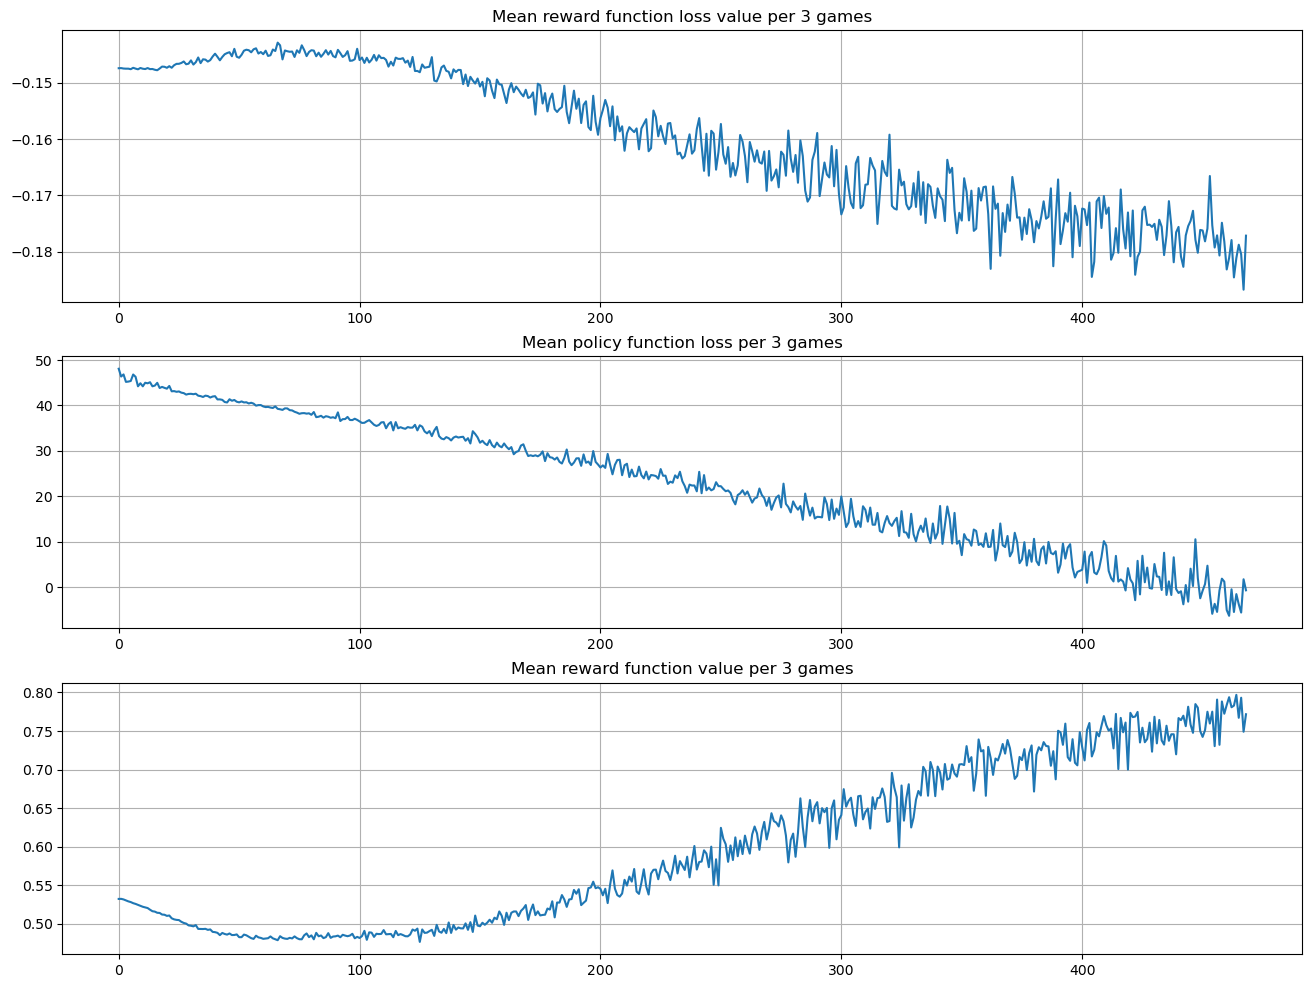

In [20]:
# print(f"mean reward loss:{np.mean(mean_loss_reward)} loss: {loss_IOC.item()}")
# print(f"mean policy loss:{np.mean(mean_loss_policy)} loss: {loss_POL.item()}")

plt.figure(figsize=[16, 12])
plt.subplot(3, 1, 1)
plt.title(f"Mean reward function loss value per {EPISODES_TO_PLAY} games")
plt.plot(mean_loss_reward)
plt.grid()

plt.subplot(3, 1, 2)
plt.title(f"Mean policy function loss per {EPISODES_TO_PLAY} games")
plt.plot(mean_loss_policy)
plt.grid()

plt.subplot(3, 1, 3)
plt.title(f"Mean reward function value per {EPISODES_TO_PLAY} games")
plt.plot(mean_reward_value)
plt.grid()

plt.show()

# Evaluate Optimized Reward Function

In [21]:
test_trajectories = []

# loop through each separate trajectory inside the testing dataset
for traj_start_index in range(len(trajectory_indices)):
    
    traj_df, reward_values_demo_data, reward_values_estim_data, logprob_action_estim_avg = \
        functions.get_estimated_rewards(configs=configs,
                                        updater_obj=updater_obj,
                                        data_loader=training_data,
                                        policy_network=updater_obj.policy_network,
                                        reward_network=updater_obj.reward_network,
                                        trajectory_indices=trajectory_indices,
                                        traj_start_index=traj_start_index,
                                        is_inference_reward=True,
                                        is_inference_policy=True,
                                        is_deterministic=True)
    
    # store outputs in the dataframe of trajectory information
    traj_df[constants.ACTION_PREDICTION_AVG_LOGPROB_NAME] = logprob_action_estim_avg.numpy().flatten()
    traj_df[constants.REWARD_DEMONSTRATION_TRAJECTORY_NAME] = reward_values_demo_data.numpy().flatten()
    traj_df[constants.REWARD_ROBOT_TRAJECTORY_NAME] = reward_values_estim_data.numpy().flatten()
    
    test_trajectories.append(traj_df)
    
    del traj_df

In [23]:
test_trajectories[-1]

,state_label_norm_1,state_label_norm_2,state_label_norm_3,state_label_denorm_1,state_label_denorm_2,state_label_denorm_3,action_label_norm_1,action_label_norm_2,action_label_norm_3,action_label_denorm_1,action_label_denorm_2,action_label_denorm_3,action_pred_logprob_1,action_pred_norm_1,action_pred_norm_2,action_pred_norm_3,action_pred_std_1,action_pred_std_2,action_pred_std_3,action_pred_denorm_1,action_pred_denorm_2,action_pred_denorm_3,trajectory_index,state_number,gnll_loss,state_est_norm_1,state_est_norm_2,state_est_norm_3,state_est_denorm_1,state_est_denorm_2,state_est_denorm_3,next_state_label_norm_1,next_state_label_norm_2,next_state_label_norm_3,next_state_label_denorm_1,next_state_label_denorm_2,next_state_label_denorm_3,next_state_est_norm_1,next_state_est_norm_2,next_state_est_norm_3,next_state_est_denorm_1,next_state_est_denorm_2,next_state_est_denorm_3,action_pred_avg_logprob,reward_demo_traj,reward_robot_traj
0,0.239584520459,0.549098074436,0.238536208868,0.718753561378,1.647294223309,0.715608626604,-0.294840991497,-0.343237370253,-0.462992191315,-0.589681982994,-0.686474800110,0.537007808685,5.180546283722,-0.276771545410,-0.235122680664,-0.375591576099,0.078413404524,0.075163058937,0.060597240925,-0.553543090820,-0.470245361328,0.624408423901,42,0,-3.079351425171,0.239584520459,0.549098074436,0.238536208868,0.718753561378,1.647294223309,0.715608626604,0.237467106593,0.544856140522,0.235169269562,0.712401319780,1.634568421567,0.705507808685,0.166554471152,0.494904171756,0.264302807967,0.499663413455,1.484712515268,0.792908423901,5.180546283722,0.464516043663,0.464516043663
1,0.237467095256,0.544856131077,0.235169276595,0.712401285768,1.634568393230,0.705507829785,-0.343397021294,-0.293848335743,-0.443808555603,-0.686794042587,-0.587696671486,0.556191444397,4.735224723816,-0.268564313650,-0.149159744382,-0.342566609383,0.092488318682,0.085618466139,0.070403456688,-0.537128686905,-0.298319458961,0.657433390617,42,1,-1.946021556854,0.166554465890,0.494904160500,0.264302819967,0.499663397670,1.484712481499,0.792908459902,0.217981396497,0.524437506881,0.241563814799,0.653944189490,1.573312520644,0.724691444397,0.114744761518,0.453975893126,0.275311130206,0.344234284553,1.361927679378,0.825933390617,4.735224723816,0.472018331289,0.640935242176
2,0.217981398106,0.524437487125,0.241563811898,0.653944194317,1.573312461376,0.724691435695,-0.381538033485,-0.232243731618,-0.422912865877,-0.763076066971,-0.464487433434,0.577087163925,4.418835163116,-0.262955248356,-0.084094405174,-0.327398985624,0.103401310742,0.093583181500,0.079055227339,-0.525910496712,-0.168188810349,0.672600984573,42,2,-1.778307437897,0.114744760096,0.453975886106,0.275311142206,0.344234280288,1.361927658319,0.825933426619,0.196668311678,0.499147023329,0.248529054642,0.590004935033,1.497441069986,0.745587163925,0.080420507784,0.423631837413,0.280366994858,0.241261523353,1.270895512240,0.841100984573,4.418835163116,0.526120603085,0.748207032681
3,0.196668326855,0.499147027731,0.248529046774,0.590004980564,1.497441083193,0.745587140322,-0.395962834358,-0.158211961389,-0.407188266516,-0.791925668716,-0.316423892975,0.592811703682,4.205156803131,-0.258985817432,-0.035601463169,-0.322800278664,0.111072279513,0.099096253514,0.086057938635,-0.517971634865,-0.071202874184,0.677199721336,42,3,-2.198513031006,0.080420508981,0.423631846905,0.280366986990,0.241261526942,1.270895540714,0.841100960970,0.168403008084,0.465053422103,0.253770567894,0.505209024253,1.395160266308,0.761311703682,0.061612883990,0.401079838495,0.281899907112,0.184838651970,1.203239515485,0.845699721336,4.205156803131,0.587319314480,0.808465659618
4,0.168403014541,0.465053439140,0.253770589828,0.505209043622,1.395160317421,0.761311769485,-0.406059920788,-0.071958206594,-0.405145823956,-0.812119841576,-0.143916368484,0.594854176044,4.079229831696,-0.256139636040,0.000774115149,-0.328075021505,0.115246966481,0.102050490677,0.091347917914,-0.512279272079,0.001548290253,0.671924948692,42,4,-2.62

In [ ]:
samp_trajs = [generate_session(t_max=constants.TRAJECTORY_SIZE,
                               updater_obj=updater_obj,
                               replay_buffer=replay_buffer,
                               is_policy_inference=True,
                               is_policy_update=False,
                               is_deterministic=True) for _ in range(EPISODES_TO_PLAY)]
samp_trajs

# Train Behavior Cloning Agent

In [ ]:
updater_obj.policy_network = RobotPolicy(state_size=configs.state_size,
                                         hidden_size=configs.hidden_size,
                                         out_size=configs.action_size,
                                         log_std_min=configs.policy_log_std_min,
                                         log_std_max=configs.policy_log_std_max,
                                         log_std_init=configs.policy_log_std_init,
                                         device=configs.device)
updater_obj.policy_optimizer = torch.optim.Adam(updater_obj.policy_network.parameters(),
                                                lr=configs.policy_lr)

In [ ]:
bc_training_epochs = 100

In [ ]:
# lambda_pg = 1.0
# lambda_bc = 1.0

# mean_loss_bc, mean_loss_pg = [], []

# for epoch in range(bc_training_epochs):
    
#     bc_loss_list, pg_loss_list = [], []
    
#     for demo_traj_df in demo_traj_list:
        
#         states_demo = torch.Tensor(demo_traj_df[[
#             "state_label_norm_1", "state_label_norm_2", "state_label_norm_3"]].values.astype(np.float32), device=configs.device)
#         actions_demo = torch.Tensor(demo_traj_df[[
#             "action_label_norm_1", "action_label_norm_2", "action_label_norm_3"]].values.astype(np.float32), device=configs.device)
#         probs_demo = torch.Tensor(np.ones((
#             actions_demo.shape[0], actions_demo.shape[1])).astype(np.float32), device=configs.device)
        
#         demo_rewards_ = updater_obj.reward_network.estimate_reward(state_action=states_demo,
#                                                                    is_inference=True)
#         cumulative_returns = get_cumulative_rewards(demo_rewards_, 0.99).to(torch.float32)
        
# #         _, _, traj_log_probs, _, actions_pred_mu_std, _ = updater_obj.policy_network.estimate_action(state=states_demo,
# #                                                                                                  is_inference=False)
# #         cumulative_log_probs = torch.cumsum(traj_log_probs, dim=0)
        
# #         loss_pg_demo = policy_gradient_loss(cumulative_log_probs=cumulative_log_probs,
# #                                             advantages=cumulative_returns)
        
#         loss_bc_traj = updater_obj.multivariate_gaussian_nll_loss(y_true=actions_demo,
#                                                                   y_pred=actions_pred_mu_std)
        
# #         total_loss = (lambda_pg * loss_pg_demo) + (lambda_bc * loss_bc_traj)
        
#         updater_obj.run_policy_optimizer(bc_loss=loss_bc_traj)
        
#         bc_loss_list.append(loss_bc_traj.item())
# #         pg_loss_list.append(loss_pg_demo.item())
    
#     mean_loss_bc.append(np.mean(bc_loss_list))
# #     mean_loss_pg.append(np.mean(pg_loss_list))

#     print("Epoch : ", epoch, " Avg. BC Loss : ", np.mean(bc_loss_list), " Avg. PG Loss : ", np.mean(pg_loss_list))

In [ ]:
# for epoch in range(bc_training_epochs):
    
#     # loop through each batch inside the dataset
#     for batch_train_data in tqdm(train_loader):
        
#         # get batch of data
#         input_state, output_action, _, _ = functions.read_each_loader(configs=configs,
#                                                                       sample_data=tuple(batch_train_data))
        
#         # forward pass to get mean of Gaussian distribution
#         action_pred, action_std, action_log_prob, action_entropy, action_mu_and_std, action_dist = \
#             policy_network.estimate_action(state=input_state,
#                                            is_inference=False)
        
#         # compute negative log-likelihood loss value for maximum likelihood estimation
#         loss_bc_traj = updater_obj.multivariate_gaussian_nll_loss(y_true=output_action,
#                                                                   y_pred=action_mu_and_std)
#         batch_loss = loss_bc_traj.mean()
        
#         updater_obj.run_policy_optimizer(bc_loss=loss_bc_traj)
        
#         loss_value = round(batch_loss.item(), 5)
#         loss_value_str = str(loss_value).replace(".", "_")
        
#     print(f"Epoch {epoch + 1}/{bc_training_epochs}, Batch Loss: {loss_value}")

In [ ]:
action_pred

In [ ]:
action_mu_and_std

# Generate Random Initial State Trajectories with Trained BC Policy

In [ ]:
for param in updater_obj.policy_network.parameters():
    param.requires_grad = False
updater_obj.policy_network = updater_obj.policy_network.eval()

In [ ]:
# bc_trajs = [generate_session(t_max=constants.TRAJECTORY_SIZE, updater_obj=updater_obj) for _ in range(5)]

In [ ]:
state_0 = generate_initial_rand_state()
input_state_norm = torch.Tensor(state_0)
    
created_trajectory_df, logprob_action_sum_tensor, reward_values_tensor = \
    functions.trajectory_generation(configs=configs,
                                    state_norms=training_data.state_norms,
                                    action_norms=training_data.action_norms,
                                    policy_network=updater_obj.policy_network,
                                    reward_network=updater_obj.reward_network,
                                    input_state_norm=input_state_norm)

In [ ]:
created_trajectory_df

In [ ]:
reward_values_tensor

# Evalutions

In [ ]:
# test_bc_trajectories = []

# # loop through each separate trajectory inside the testing dataset
# for traj_start_index in range(len(trajectory_indices)):
    
#     traj_df, reward_values_demo_data, reward_values_estim_data, logprob_action_estim_avg = \
#         functions.get_estimated_rewards(configs=configs,
#                                         updater_obj=updater_obj,
#                                         data_loader=training_data,
#                                         policy_network=updater_obj.policy_network,
#                                         reward_network=updater_obj.reward_network,
#                                         trajectory_indices=trajectory_indices,
#                                         traj_start_index=traj_start_index,
#                                         is_inference_reward=True,
#                                         is_inference_policy=True)
    
#     # store outputs in the dataframe of trajectory information
#     traj_df[constants.ACTION_PREDICTION_AVG_LOGPROB_NAME] = logprob_action_estim_avg.numpy().flatten()
#     traj_df[constants.REWARD_DEMONSTRATION_TRAJECTORY_NAME] = reward_values_demo_data.numpy().flatten()
#     traj_df[constants.REWARD_ROBOT_TRAJECTORY_NAME] = reward_values_estim_data.numpy().flatten()
    
#     test_bc_trajectories.append(traj_df)
    
#     del traj_df

In [ ]:
# test_bc_trajectories[-1]